<a href="https://colab.research.google.com/github/cacordobae/An-lisis-a-mediciones-de-ruido/blob/main/Estad%C3%ADstica_aplicada%7CMedicionesdeRuido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importamos las librerías que vamos a utilizar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyproj import Proj
import folium
from folium.plugins import MarkerCluster, HeatMap
from scipy import stats
from plotnine import *

In [3]:
# Leemos el conjunto de datos
data = pd.read_excel('/estadisticaaplicada.xlsx')


En el archivo de Excel se encuentra la base de datos de muestra con 445 mediciones de ruido, de las cuales se tiene información del Grupo de Exposición Similar (GES) al que corresponde cada muestra y del valor límite permisible (TLV). Teniendo en cuenta las siguientes definiciones:
•	**Grupo de Exposición Similar** (GES): Conjunto de trabajadores en los cuales se asume que se tiene el mismo perfil de exposición de un factor de riesgo determinado, en términos de la frecuencia con que se desarrolla una tarea u oficio, los materiales utilizados y los procesos implicados en general.

•	**Valor Límite Permisible** (TLV): Nivel al que un trabajador puede estar expuesto por turno en el tiempo de trabajo sin efectos adversos.



# Preparación de los datos

In [4]:
# Vemos la información del conjunto de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Consecutivo muestra  445 non-null    int64  
 1   GES                  445 non-null    object 
 2   SPL (dBA)            445 non-null    float64
 3   TLV (dBA)            445 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 14.0+ KB


Hay 445 registros en 4 columnas

In [5]:
# Consultamos los primeros valores
data.head()

,Consecutivo muestra,GES,SPL (dBA),TLV (dBA)
0,1,Operador de Planta,70.7,85
1,2,Operador de Planta,71.8,85
2,3,Operador de Planta,71.1,85
3,4,Operador de Máquina,71.8,85
4,5,Operador de Planta,72.6,85


In [6]:
# Descripción del conjunto de datos
data.describe()

,Consecutivo muestra,SPL (dBA),TLV (dBA)
count,445.000000,445.000000,445.0
mean,223.000000,80.361573,85.0
std,128.604691,7.177573,0.0
min,1.000000,63.400000,85.0
25%,112.000000,75.000000,85.0
50%,223.000000,81.100000,85.0
75%,334.000000,84.900000,85.0
max,445.000000,109.200000,85.0


El nivel de presión sonora(SPL (dBA)) al que está expuesto el conjunto de colaboradores, nos indica que en promedio el conjunto de colaboradores está expuesto en un 80.36 puntos de presión sonora.
El valor mínimo que presenta es de 63.40 puntos de presión sonora y el valor máximo es de 109.20 puntos de presión sonora.

In [7]:
# Mostramos True si en la columna hay valores nulos
data.isnull().any()

Consecutivo muestra    False
GES                    False
SPL (dBA)              False
TLV (dBA)              False
dtype: bool

No hay valores nulos en las columnas

In [8]:
# Comprobamos si hay datos duplicados
data.duplicated().any()

False

No hay registros duplicados.
Ahora vamos a convertir en numéricos los valores de la columna GES.

In [9]:
# En la columna GES, sustituimos los valores "Operador de Máquina","Operador de Planta","Operador de Taladro","Supervisor" por 0, 1, 2 y 3 para hacer numérica la columna
data['GES'] = data['GES'].map({'Operador de Máquina': 0, 'Operador de Planta': 1, 'Operador de Taladro': 2, 'Supervisor': 3}).astype(int)

In [10]:
# Vemos como queda el conjunto de datos
data.head()

,Consecutivo muestra,GES,SPL (dBA),TLV (dBA)
0,1,1,70.7,85
1,2,1,71.8,85
2,3,1,71.1,85
3,4,0,71.8,85
4,5,1,72.6,85


# Análisis exploratorio de los datos de muestra.

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
      dtype=object)

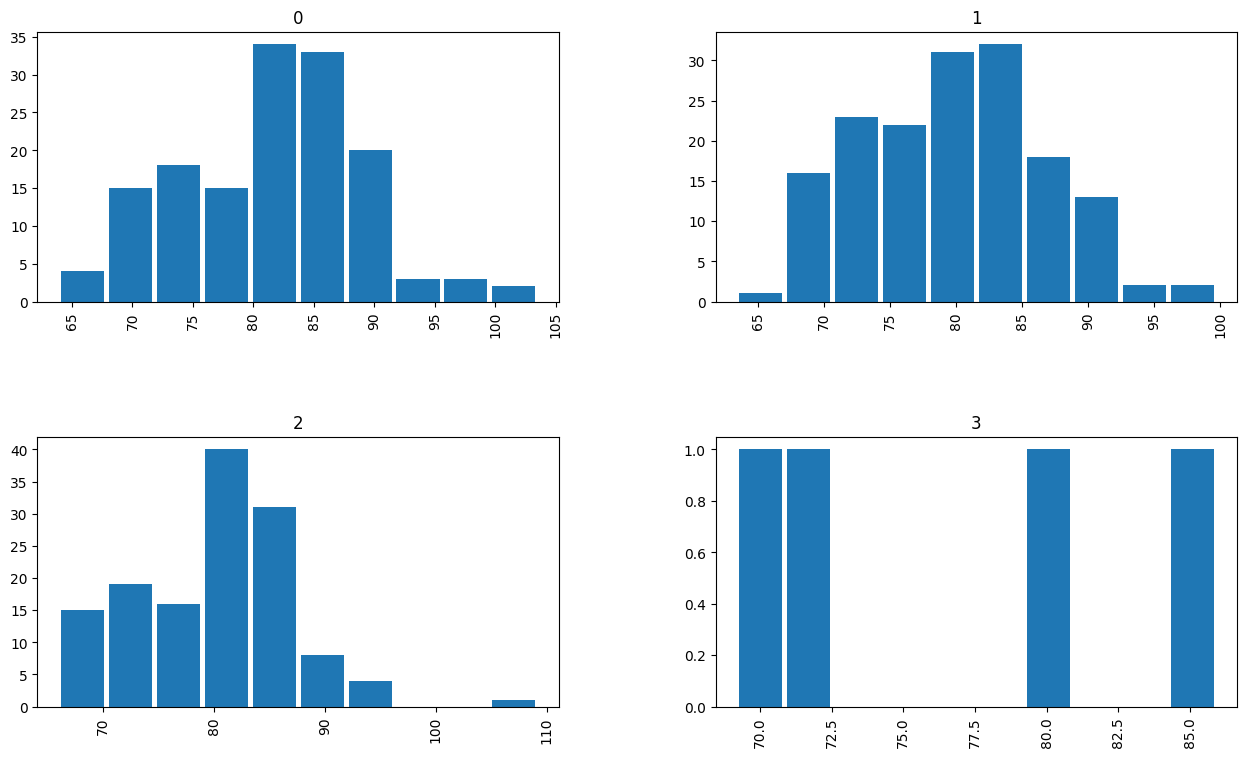

In [11]:
# Histograma de las muestras
data.hist(column='SPL (dBA)', by= 'GES',figsize=(15,9), rwidth=0.9)

Observamos que los datos medidos de presión sonora para los grupos de exposición similar están sesgados levemente hacia la derecha,

Text(0.5, 1.0, 'Mediciones')

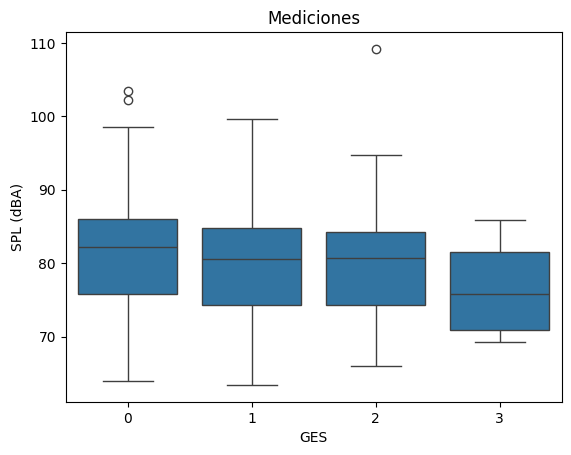

In [12]:
# Diagrama de cajas entre las mediciones y el momento de la medición (GES)
sns.boxplot(x='GES',y='SPL (dBA)',data=data).set_title("Mediciones")

El diagrama de caja nos muestra que el GES 3( Supervisor) es quien presenta una mediana inferior.Los GES 1( Operador de planta) y GES 2(Operador de Taladro) presentan resultados similares en cuando a su mediana ponderada, también observamos que los gráficos se superponen. Los datos para el GES 1 tienen un tendencia superior a presentar mayor nivel de SPL (dBA) que los del GES 2, sin embargo, el GES 2 presenta un valor atípico muy alejado de los valores esperados de exposición de presión sonora.
El GES 0(Operador de Máquina) presenta una mediana de exposición a la presión sonora más alta que el resto de los GES medidos.

In [13]:
#vamos a ver la frecuencia
(data.groupby("GES").agg(frequency=("GES", "count")))

,frequency
GES,
0,147
1,160
2,134
3,4


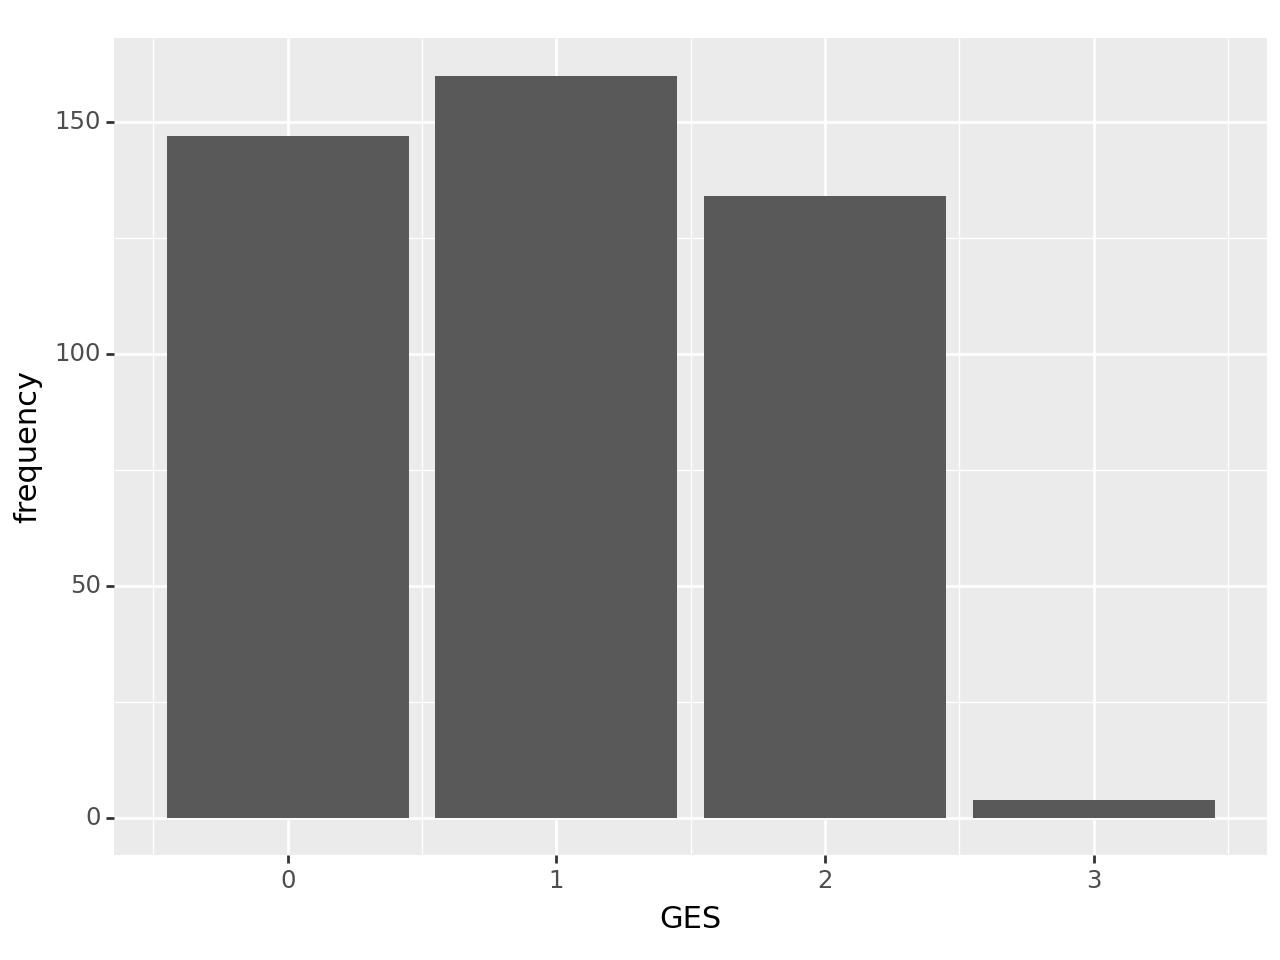

<Figure Size: (640 x 480)>

In [14]:
freq_by_GES = (data.groupby("GES").agg(frequency=("GES", "count")).reset_index())

(ggplot(freq_by_GES, aes(x = "GES", y = "frequency")) +
  geom_bar(stat = 'identity'))

Observando la información gráfica,vamos a determinar los supuestos de normalidad se cumplen para nuestros datos de muestra.

**Comprobación de supuestos de normalidad.**

La siguiente prueba está basada en la prueba de D’Agostino y Pearson, que combina sesgo y curtosis para producir una prueba general (omnibus) de normalidad.

In [17]:
# D’Agostino y Pearson
# H_0 Los datos vienen de una distribución normal


stats.normaltest(data)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1808: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


NormaltestResult(statistic=array([273.64441573, 410.68705599,   2.61229205,          nan]), pvalue=array([3.79201567e-60, 6.61361481e-90, 2.70861943e-01,            nan]))

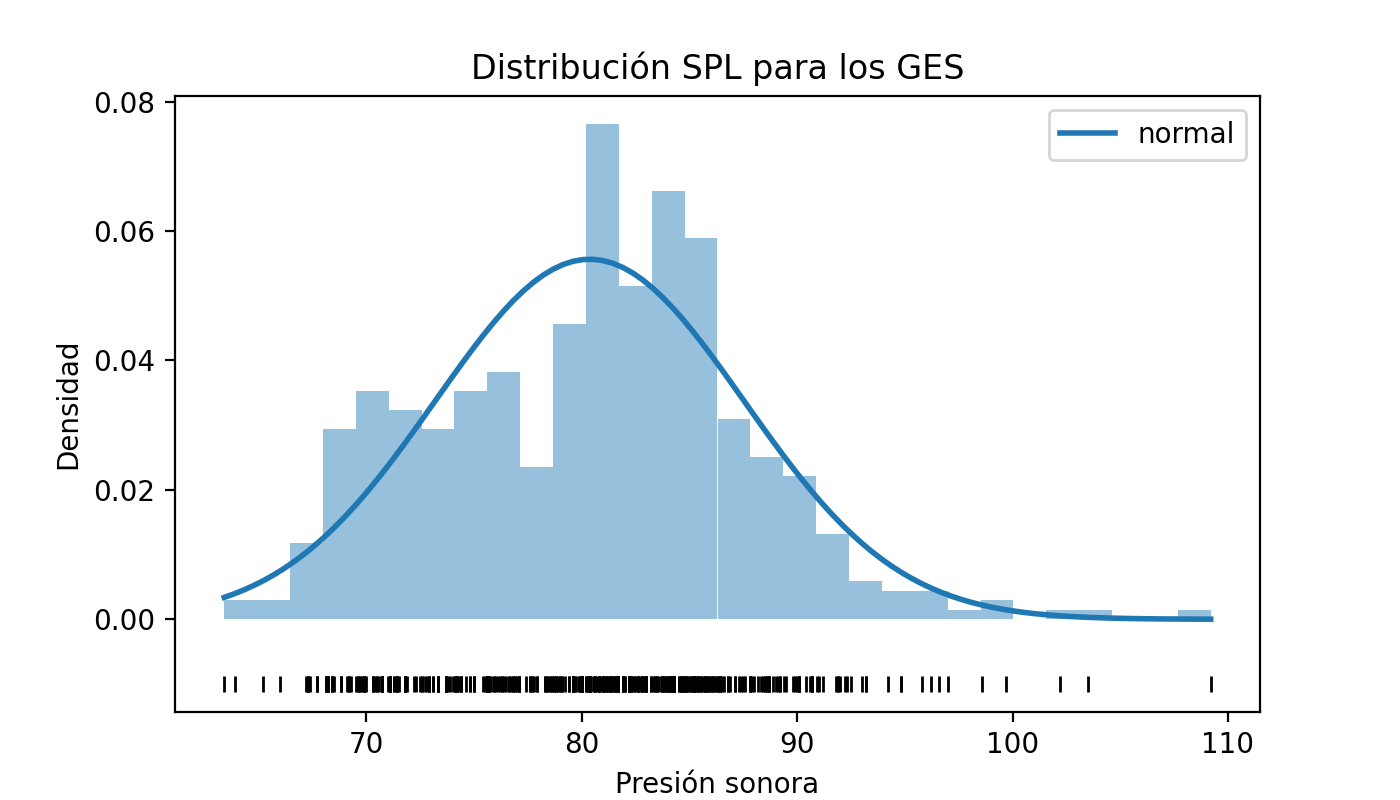

In [20]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(data['SPL (dBA)'])

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(data['SPL (dBA)']), max(data['SPL (dBA)']), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=data['SPL (dBA)'], density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(data['SPL (dBA)'], np.full_like(data['SPL (dBA)'], -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución SPL para los GES')
ax.set_xlabel('Presión sonora')
ax.set_ylabel('Densidad')
ax.legend();

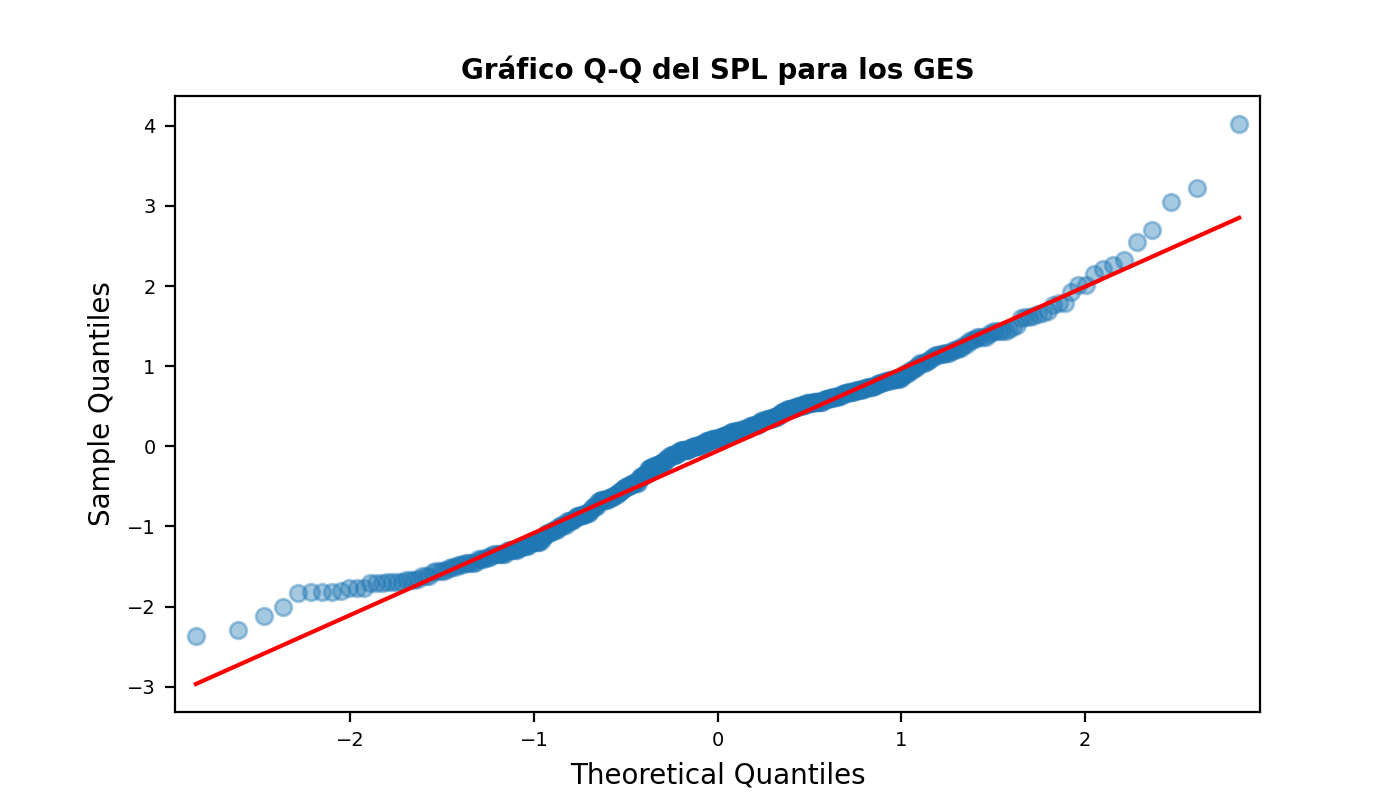

In [21]:
import statsmodels.api as sm
from scipy import stats

# Gráfico Q-Q
# ==============================================================================
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(
    data['SPL (dBA)'],
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q del SPL para los GES', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)

In [22]:
# D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(data['SPL (dBA)'])
print(f"Estadístico = {k2}, p-value = {p_value}")

Estadístico = 2.6122920494207835, p-value = 0.270861942626945


Dadas las evidencias gráficas y tomando en cuenta el test de normalidad,
el p-value de estos test indica la probabilidad de obtener unos datos como los observados como si realmente procediesen de una población con una distribución normal con la misma media y desviación que estos. Por lo tanto, niguno de los test muestra evidencias para rechazar la hipótesis nula de que los datos se distribuyen de forma normal.

Retomemos la frecuencia en que están dados los GES, esto con el fin de conformar nuevos grupos. El GES debe ser conformado por un tamaño de muestra mayor o igual a 5.


# Determinando el GES MAYOR O IGUAL A 5

In [23]:
#vamos a ver la frecuencia
(data.groupby("GES").agg(frequency=("GES", "count")))

,frequency
GES,
0,147
1,160
2,134
3,4


Vemos que el grupo GES 3(Supervisor), únicamente contiene 4 muestras, Por tanto, para determinar si se considera en el análisis de GES, se considera la siguiente definición:
GES: Conjunto de trabajadores en los cuales se asume que se tiene el mismo perfil de exposición de un factor de riesgo determinado, en términos de la frecuencia con que se desarrolla una tarea u oficio, los materiales utilizados y los procesos implicados en general.

Si tomo en cuenta los demás grupos que estoy analizando, mis otros tres grupos GES son trabajadores pertenecientes a un conjunto de colaboradores que tienen perfiles similares de exposición("Operador de Máquina","Operador de Planta","Operador de Taladro").
Por tal motivo y dando cumplimiento al objetivo de los GES, se elimina la categoría 'Supervisor' de mis datos a analizar, ya que no es factor de estudio para este análisis.

In [24]:
#Removiendo la categoria 'Supervisor' de mi conjunto de datos
data = data[data['GES'] !=3]

In [25]:
print(data)

     Consecutivo muestra  GES  SPL (dBA)  TLV (dBA)
0                      1    1       70.7         85
1                      2    1       71.8         85
2                      3    1       71.1         85
3                      4    0       71.8         85
4                      5    1       72.6         85
..                   ...  ...        ...        ...
440                  441    0       85.7         85
441                  442    1       83.0         85
442                  443    0       98.6         85
443                  444    0       82.3         85
444                  445    0       80.2         85

[441 rows x 4 columns]


In [26]:
data.sample(n=10) #confirmando que eliminamos la categoria GES 3

,Consecutivo muestra,GES,SPL (dBA),TLV (dBA)
7,8,1,75.6,85
424,425,1,86.3,85
155,156,1,85.7,85
227,228,0,74.6,85
127,128,0,83.6,85
421,422,0,85.1,85
205,206,0,81.9,85
295,296,2,77.0,85
19,20,1,69.2,85
323,324,1,84.5,85


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object)

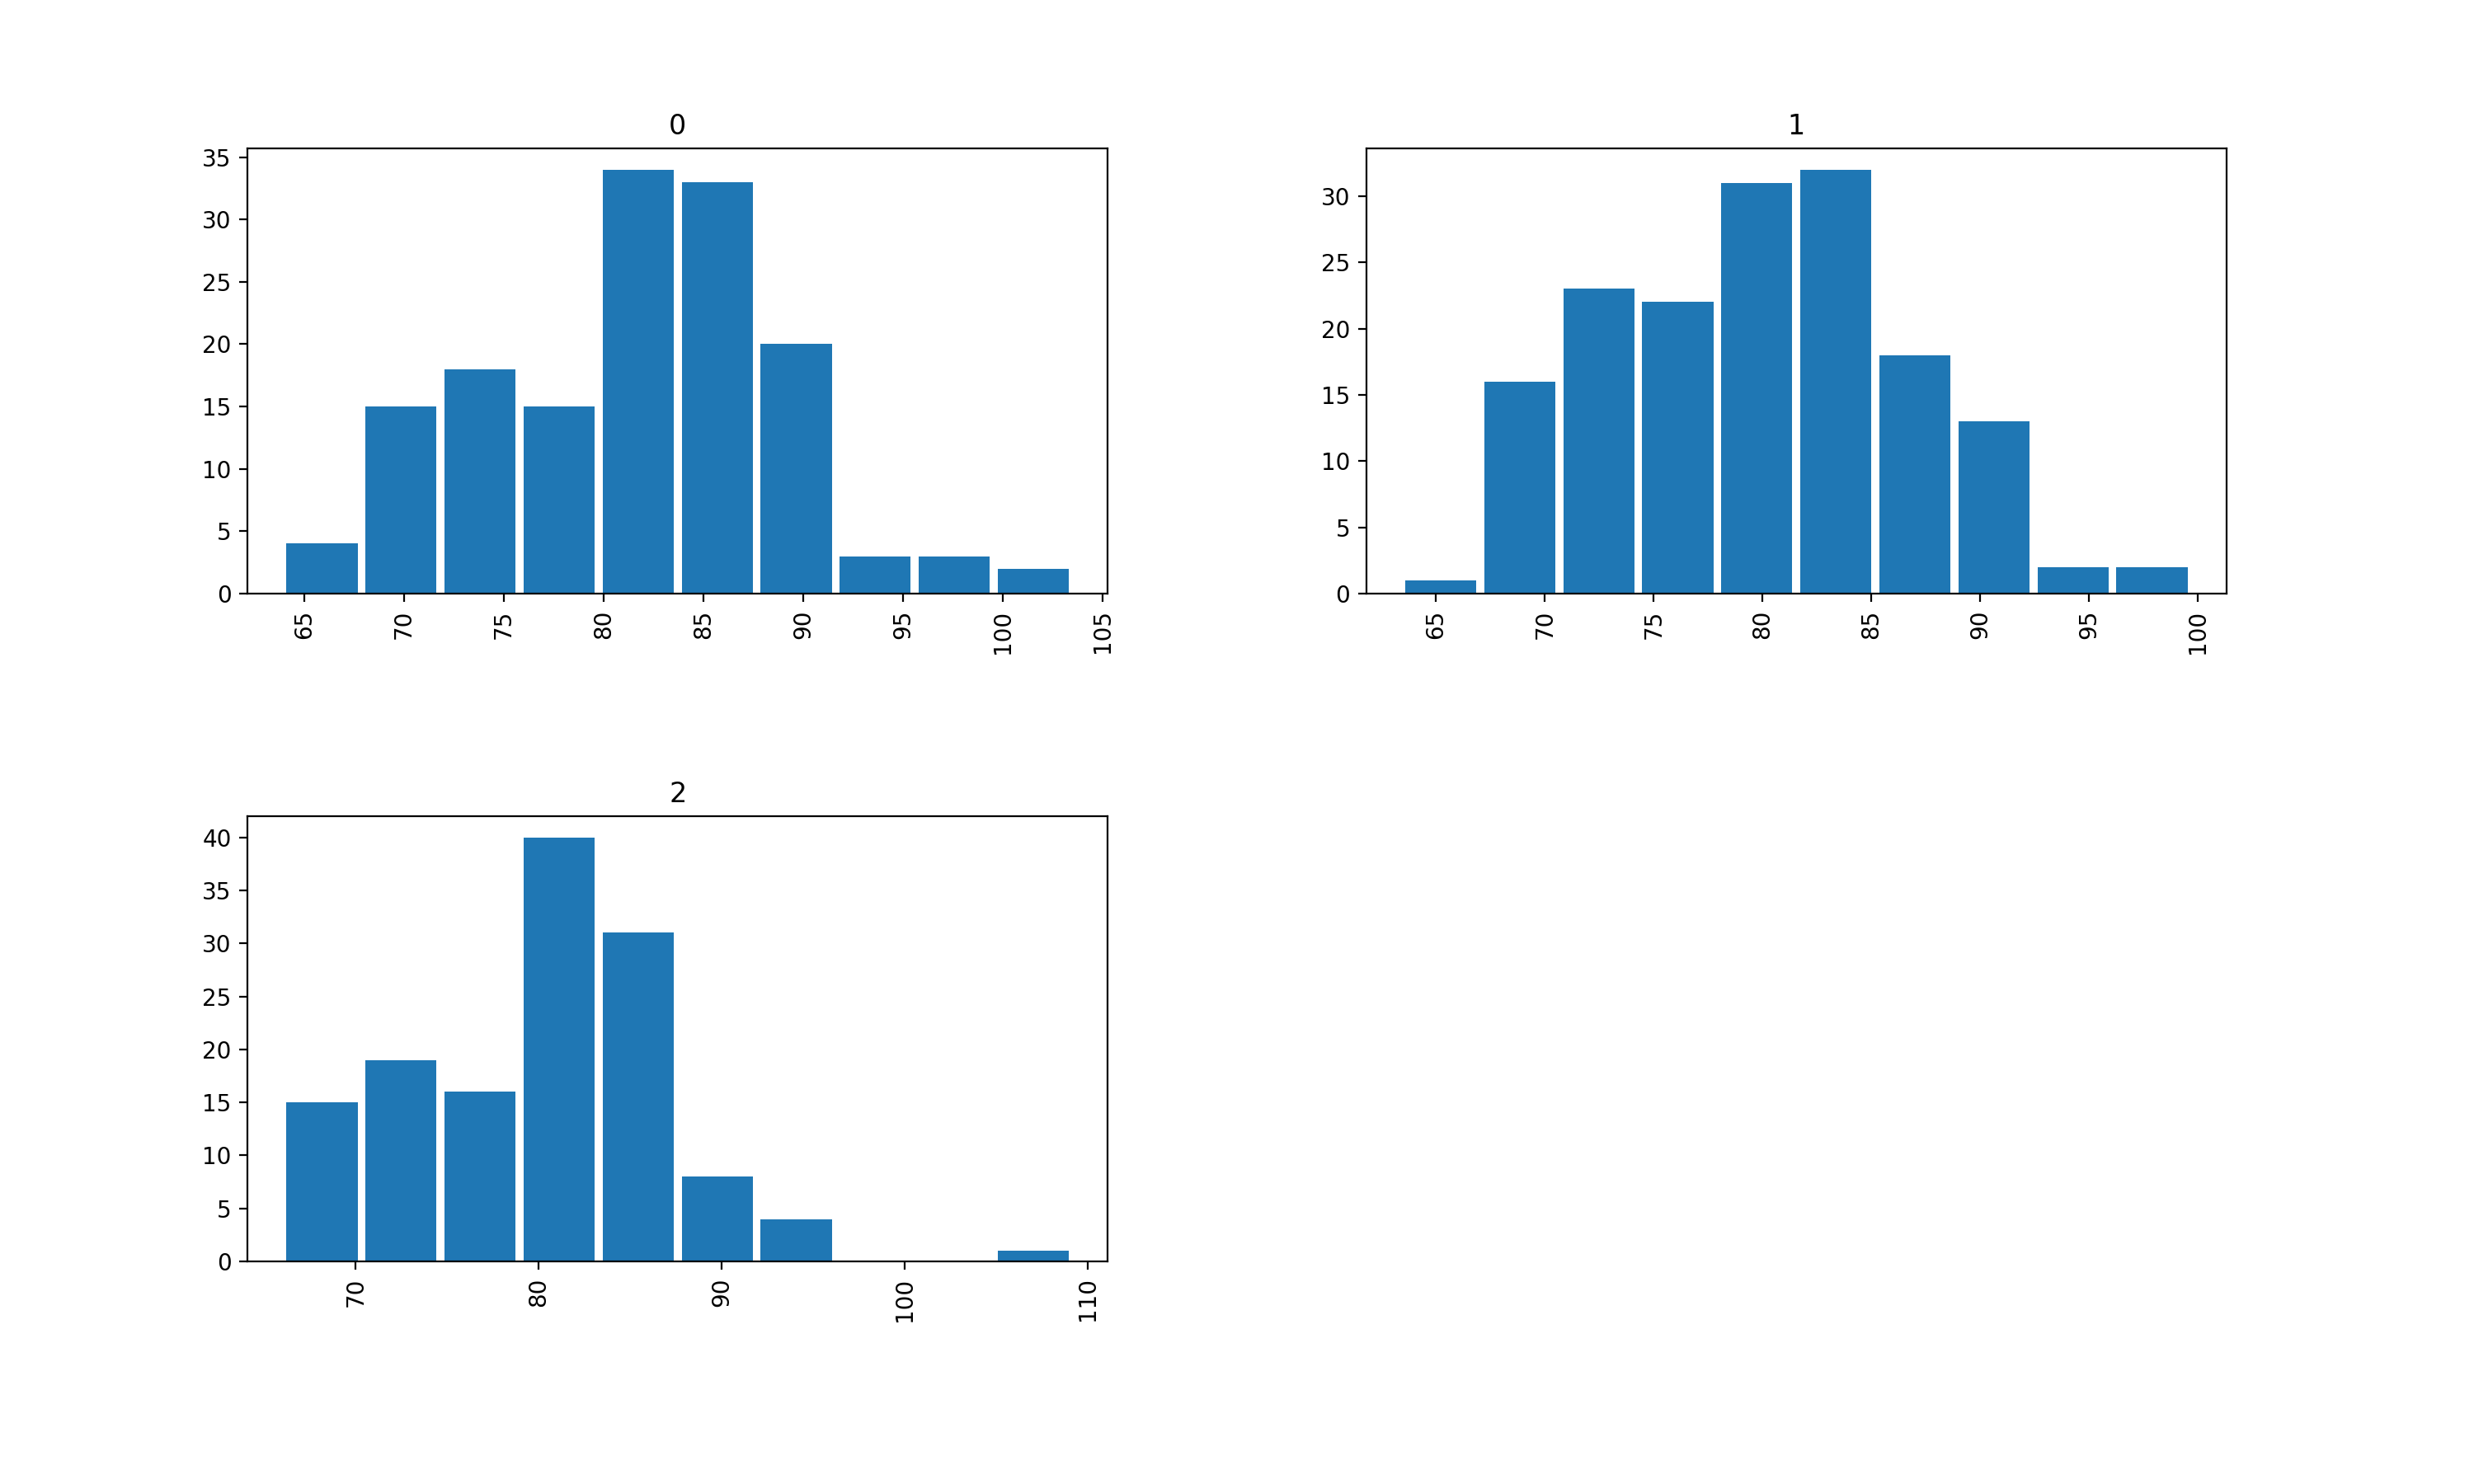

In [27]:
# Histograma de las muestras
data.hist(column='SPL (dBA)', by= 'GES',figsize=(15,9), rwidth=0.9)

**Calculo de valores atípicos.**

In [28]:
#Calcular el IQR para cada columna

Q1= data.quantile(0.25)
Q3= data.quantile(0.75)
IQR= Q3 - Q1



In [29]:
#Definiendo los limites para determinar outliers
lim_infe= Q1 - 1.5 * IQR
lim_sup= Q3 + 1.5* IQR

In [30]:
#Filtrando las filas que no tienen outliers en ninguna columna
data_filtrado = data[((data >= lim_infe) & (data <= lim_sup)).all(axis=1)]

In [31]:
print(data_filtrado)

     Consecutivo muestra  GES  SPL (dBA)  TLV (dBA)
0                      1    1       70.7         85
1                      2    1       71.8         85
2                      3    1       71.1         85
3                      4    0       71.8         85
4                      5    1       72.6         85
..                   ...  ...        ...        ...
440                  441    0       85.7         85
441                  442    1       83.0         85
442                  443    0       98.6         85
443                  444    0       82.3         85
444                  445    0       80.2         85

[438 rows x 4 columns]


De los 445 registros que se tenían inicialmente, 438 registros quedaron después de eliminar los valores atípicos de nuestra muestra de datos de medición de ruido.

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object)

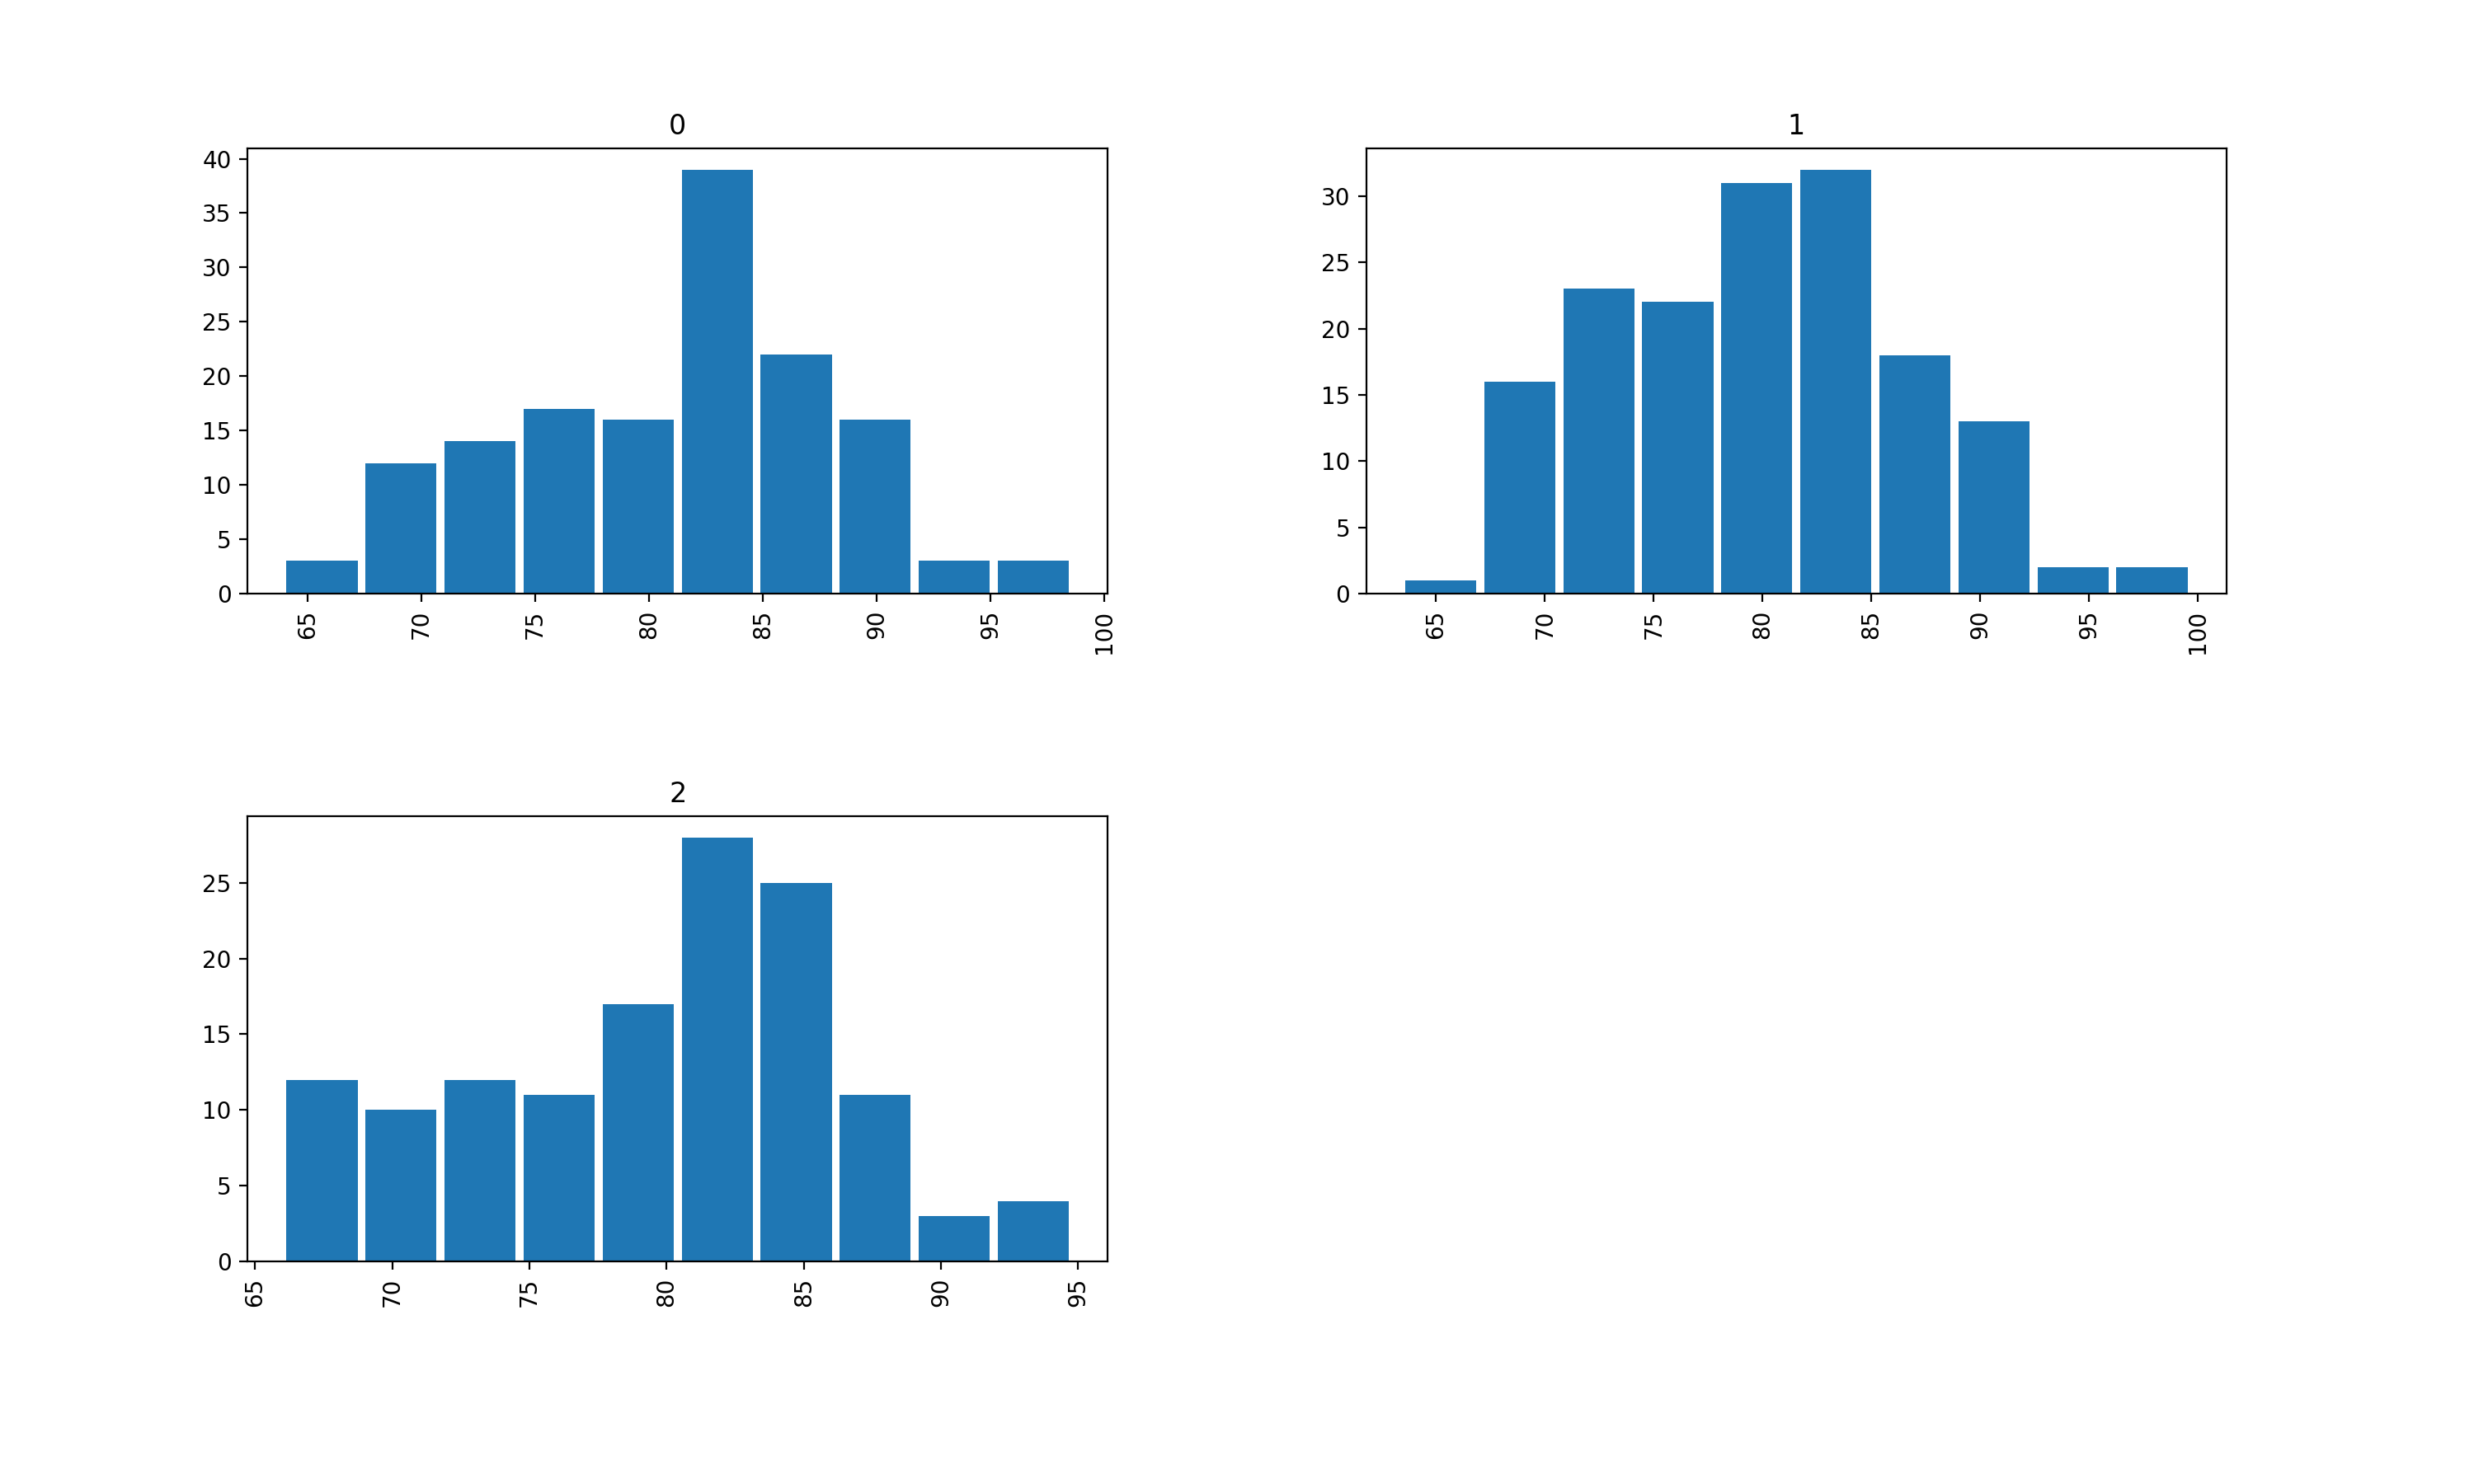

In [32]:
# Histograma de las muestras sin outliers
data_filtrado.hist(column='SPL (dBA)', by= 'GES',figsize=(15,9), rwidth=0.9)

Text(0.5, 1.0, 'Mediciones')

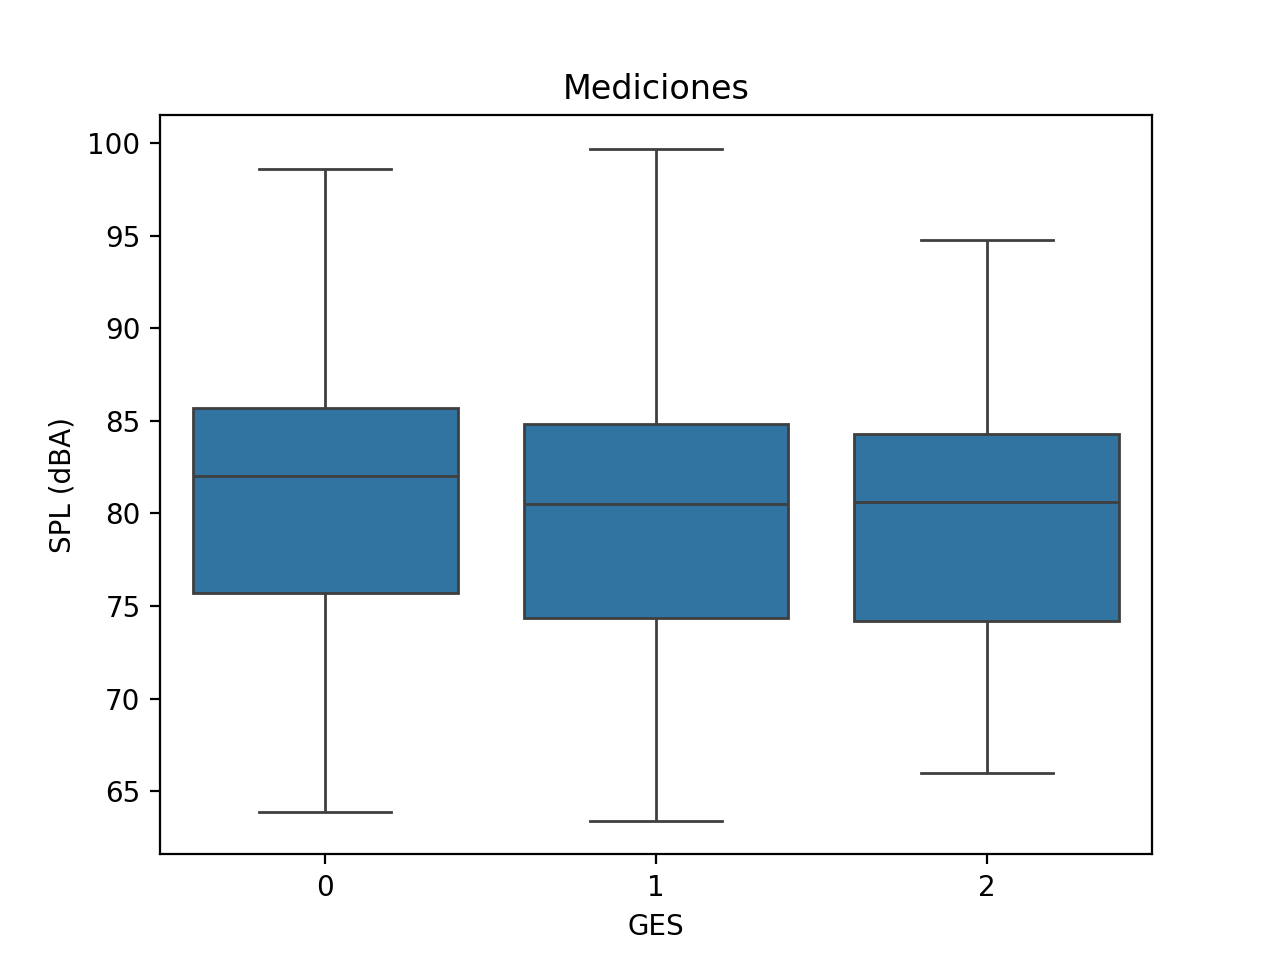

In [33]:
# Diagrama de cajas entre las mediciones y el momento de la medición (GES)
sns.boxplot(x='GES',y='SPL (dBA)',data=data_filtrado).set_title("Mediciones")

Del gráfico de cajas, observamos que los GES se superponen.
El GES 0 tiene un tendencia a la exposición de presión sonora más alta que el resto de los GES 1 y GES 2.



**Comprobación de normalidad para los datos de muestra sin outliers.**

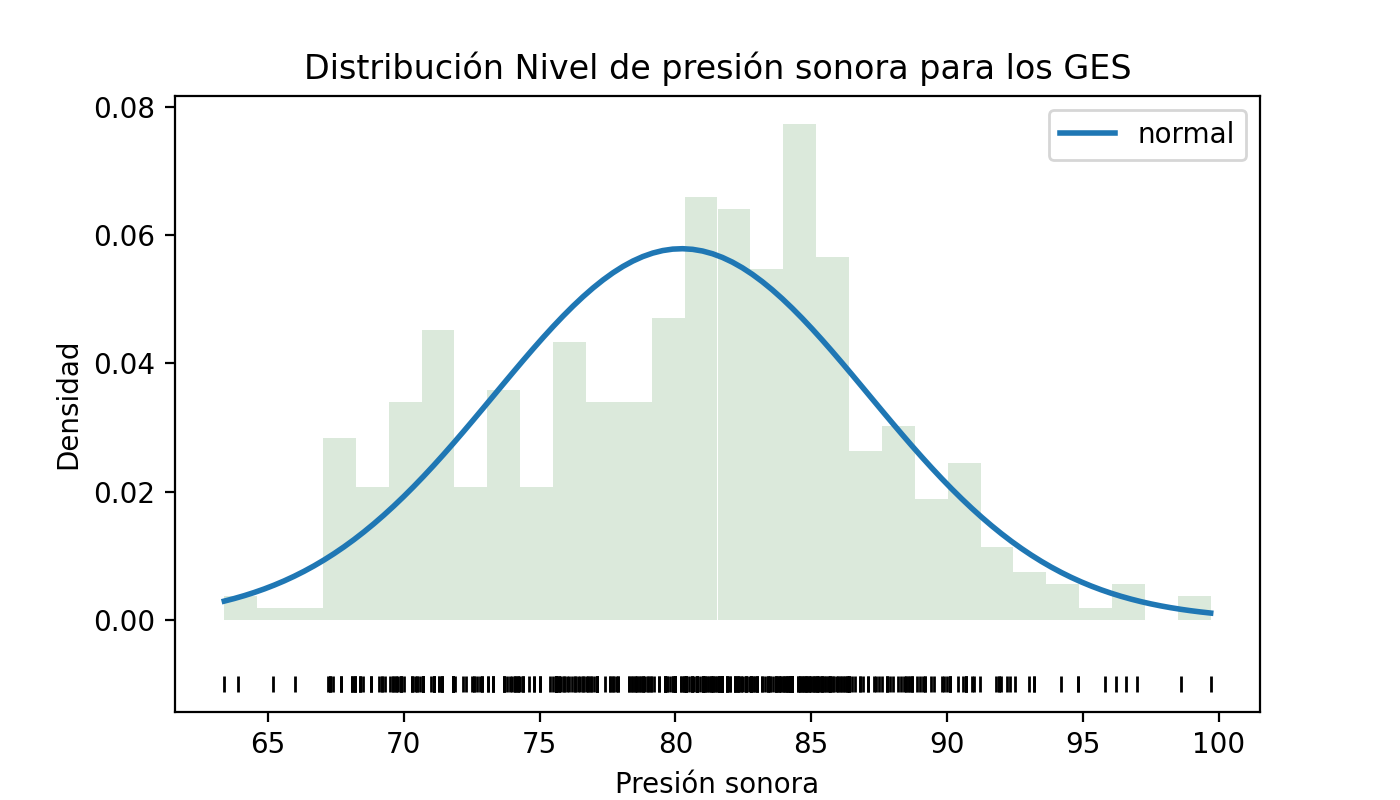

In [34]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos sin outliers
mu, sigma = stats.norm.fit(data_filtrado['SPL (dBA)'])

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(data_filtrado['SPL (dBA)']), max(data_filtrado['SPL (dBA)']), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=data_filtrado['SPL (dBA)'], density=True, bins=30, color="#B8D5B8", alpha=0.5)
ax.plot(data_filtrado['SPL (dBA)'], np.full_like(data_filtrado['SPL (dBA)'], -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución Nivel de presión sonora para los GES')
ax.set_xlabel('Presión sonora')
ax.set_ylabel('Densidad')
ax.legend();

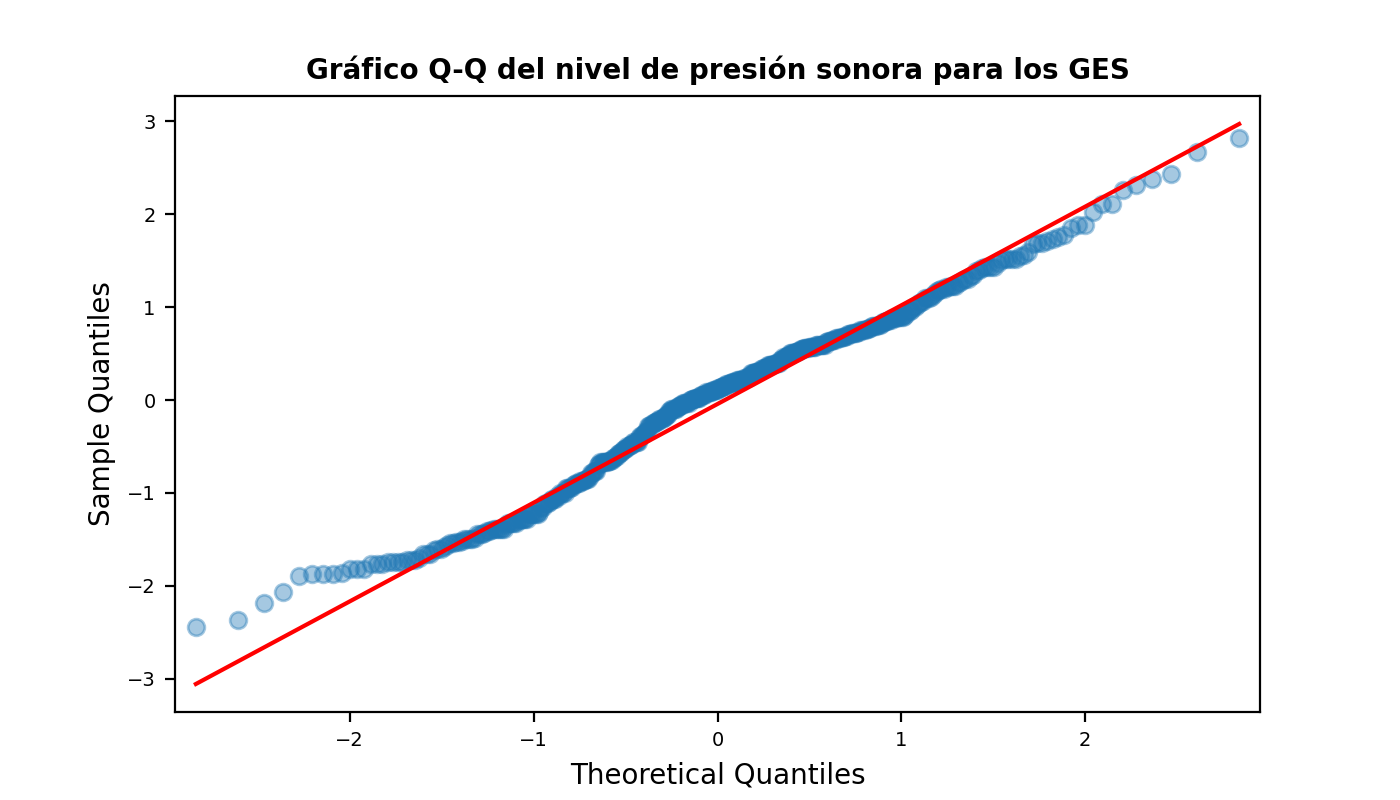

In [35]:
# Gráfico Q-Q para los datos de muestra sin outliers
# ==============================================================================
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(
    data_filtrado['SPL (dBA)'],
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q del nivel de presión sonora para los GES', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)

Como observamos el el gráfico Q-Q, los cuantiles observados se alinean con los cuantiles esperados de una distribución normal, ya que los puntos están muy cerca a la línea diagonal.

In [36]:
# D'Agostino's K-squared test para los datos de muestra sin outliers
# ==============================================================================
k2, p_value = stats.normaltest(data_filtrado['SPL (dBA)'])
print(f"Estadístico = {k2}, p-value = {p_value}")

Estadístico = 7.15079014109827, p-value = 0.028004359890623227


Dado que el estadístico de prueba p-value del test de D'Agostino's es mayor al p-value supuesto de un valor de p-value= 0.05, la hipótesis nula indicada para los test es que la Distribución es normal, No se tiene suficiente evidencia muestral para rechazarla.






# Calculo del coeficiente de variación.

El coeficiente de variación es una medida de dispersión que se calcula como el cociente entre la desviación estándar y la media de un conjunto de datos.
Para nuestra muestra de datos, Aseguraremos un coeficiente de variariación sea menor al 50%.

In [37]:
#calcular la media y la desviación estándar para cada columna de la muestra de datos
media = data_filtrado.mean()
desv_estandar = data_filtrado.std()

In [38]:
#calculando el coeficiente de variación
coef_variacion = (desv_estandar / media) * 100

In [39]:
#comprobar que el coeficiente de variación es menor al 50%
cumple_condicion = (coef_variacion < 50).all()

In [40]:
if cumple_condicion:
    print("El coeficiente de variación es menor al 50% en todas las columnas.")
else:
    print("El coeficiente de variación es mayor o igual al 50% en al menos una columna.")

El coeficiente de variación es mayor o igual al 50% en al menos una columna.


Ya que el coeficiente de variación es mayor al 50% en al menos una columna, vamos a calcular el coeficiente de variación en cada columna y luego iteramos los datos para garantizar que el coeficiente de variación sea menor al 50%.En este caso, vamos a multiplicar los datos por un valor aleatorio entre 0.5 y 1.0 para reducir la variabilidad.

In [43]:
# Modificar los datos para que el Coeficiente de Variación sea menor al 50%
for col in data_filtrado.columns:
    while coef_variacion[col] >= 50:#multiplicar cada valor de la columna por un factor aleatorio entre 0.5 y 1.0
        data_filtrado[col] = data_filtrado[col] * np.random.uniform(0.5, 1.0, len(data_filtrado))
        #recalcular el coeficiente de variación después de la modificación
        coef_variacion[col] = np.std(data_filtrado[col]) / np.mean(data_filtrado[col]) * 100

#imprimir dataframe modificado
print(data_filtrado)


<ipython-input-43-e4933426ff4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


     Consecutivo muestra            GES  SPL (dBA)  TLV (dBA)
0          4.940656e-324  6.095765e-167       70.7         85
1          4.940656e-324  2.729098e-172       71.8         85
2          4.940656e-324  6.817137e-168       71.1         85
3          4.940656e-324   0.000000e+00       71.8         85
4          4.940656e-324  3.931878e-169       72.6         85
..                   ...            ...        ...        ...
440        4.940656e-324   0.000000e+00       85.7         85
441        4.940656e-324  4.206987e-168       83.0         85
442        4.940656e-324   0.000000e+00       98.6         85
443        4.940656e-324   0.000000e+00       82.3         85
444        4.940656e-324   0.000000e+00       80.2         85

[438 rows x 4 columns]
